# Idősoros adatelemzés alapok


In [1]:
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
#from tqdm import tqdm_notebook
#TODO: Ezt fel kell rakni

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
PATH_TO_DATA = '../data/raw/train15.csv'
df = pd.read_csv(PATH_TO_DATA)
dateparse = lambda x: pd.datetime.strptime(x, '%Y%m%d %H:%M')
df["TIMESTAMP"] = df["TIMESTAMP"].apply(dateparse)
df = df.set_index('TIMESTAMP')
df = df[df["ZONEID"] == 1]

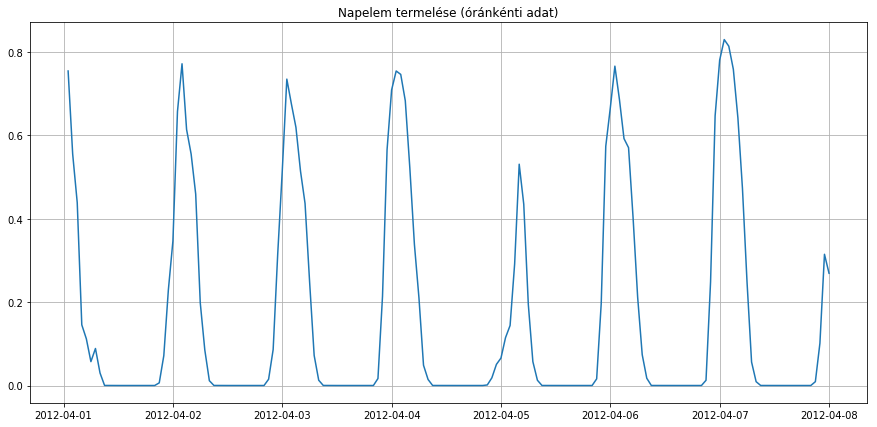

In [3]:
plt.figure(figsize=(15, 7))
plt.plot(df.POWER[0:7*24])
plt.title('Napelem termelése (óránkénti adat)')
plt.grid(True)
plt.show()

In [5]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [6]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = series
            #pd.DataFrame(series)
            #print(anomalies)
            #print(series)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

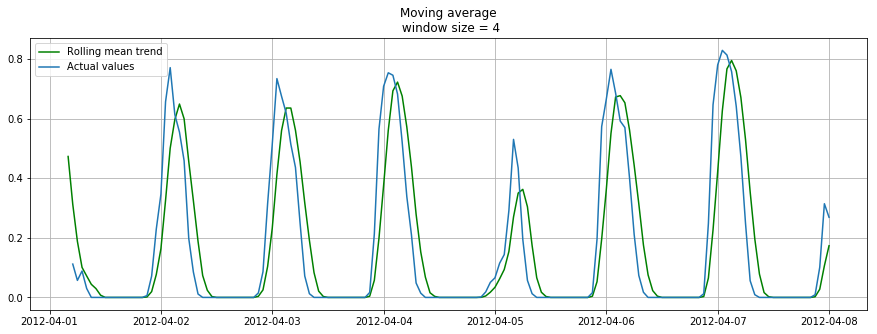

In [7]:
plotMovingAverage(df.POWER[0:7*24], 4) 

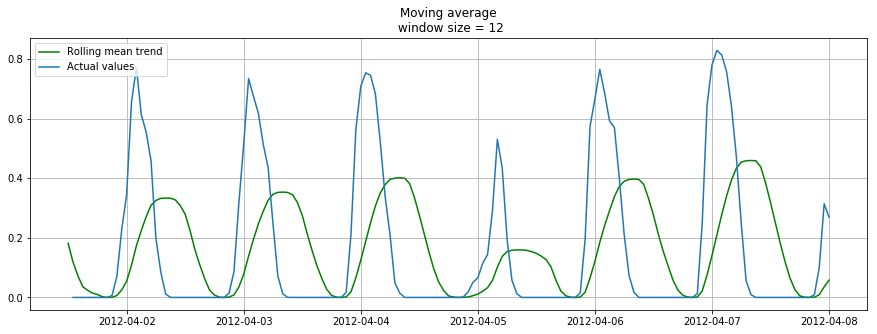

In [8]:
plotMovingAverage(df.POWER[0:7*24], 12) 

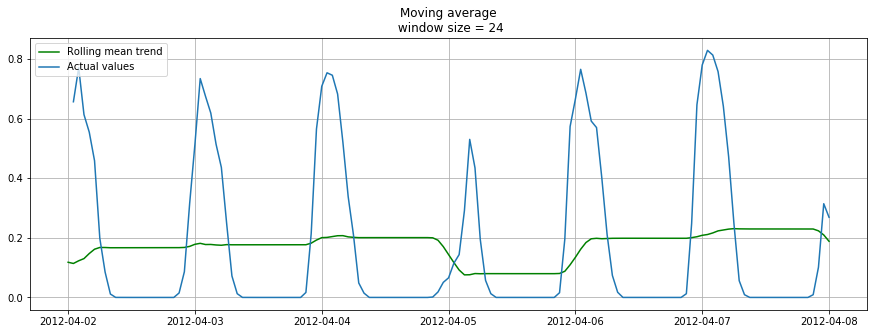

In [12]:
plotMovingAverage(df.POWER[0:7*24], 24) 

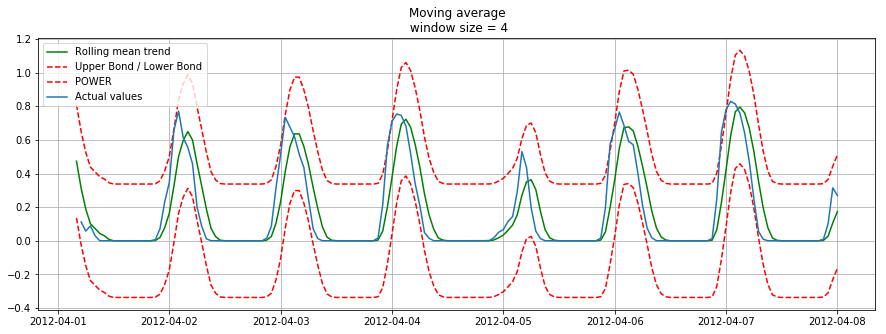

In [9]:
plotMovingAverage(df.POWER[0:7*24], 4, plot_intervals=True)


In [10]:
df_anomaly = df.POWER.copy()
#df_anomaly.iloc[-15] = 2 # say we have 80% drop of ads 


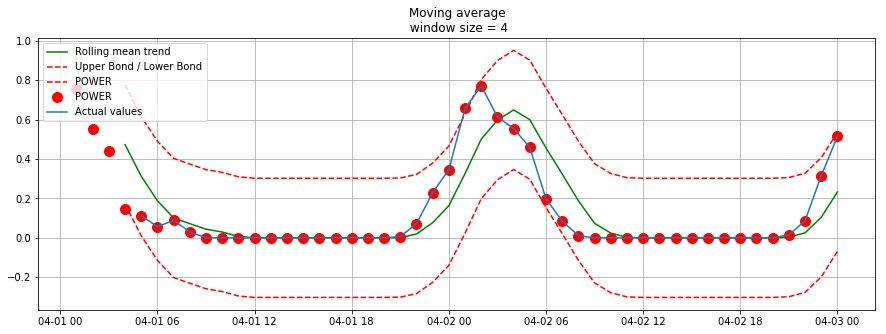

In [11]:
plotMovingAverage(df_anomaly[:48], 4, plot_intervals=True, plot_anomalies=True)


# EXPERIMENTING

In [12]:
df = df[:7*24]

In [18]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

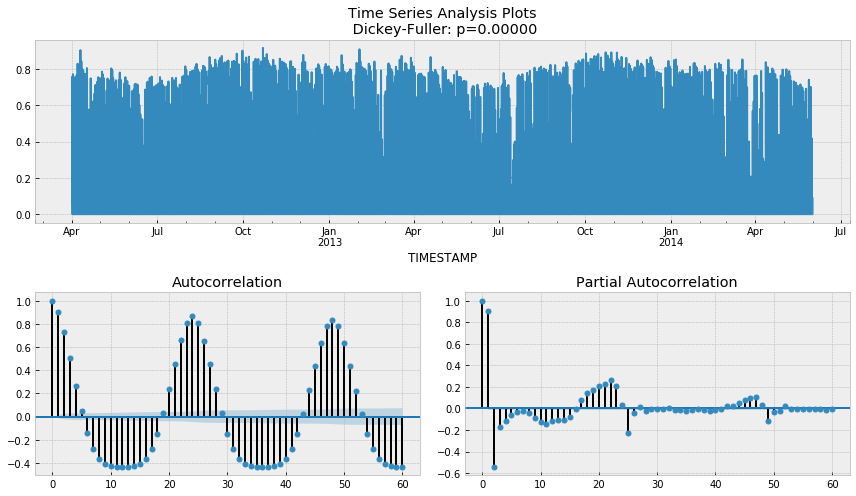

In [19]:
tsplot(df.POWER, lags=60)

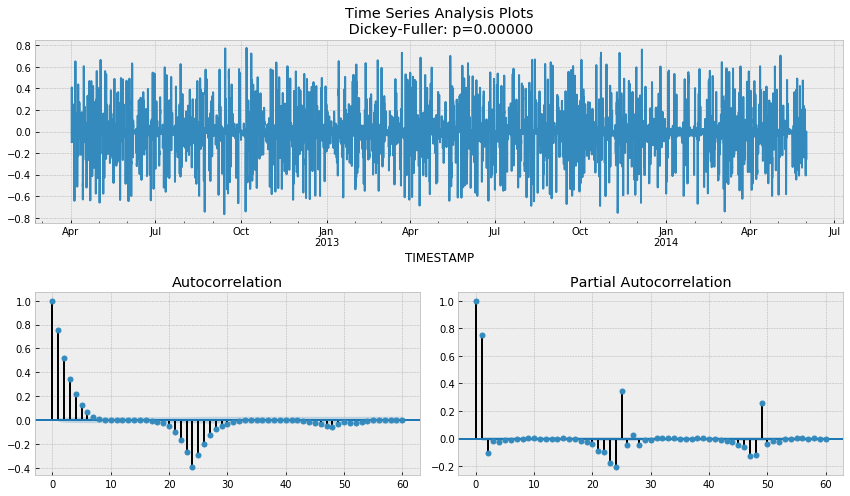

In [20]:
power_diff = df.POWER - df.POWER.shift(24)
tsplot(power_diff[24:], lags=60)

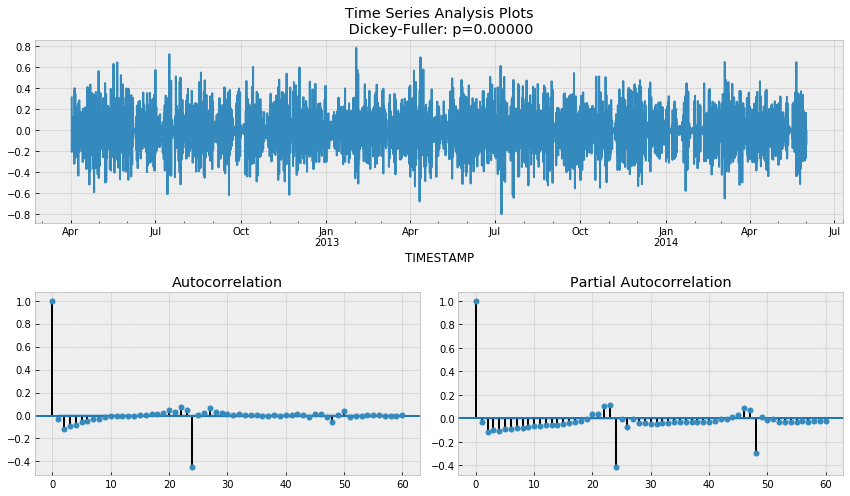

In [21]:
power_diff = power_diff - power_diff.shift(1)
tsplot(power_diff[24+1:], lags=60)

In [22]:

#p =5
#d=1
#q is 1
#P should definitely be 2 period is 24, 24,48 are peaks. 
# D is 1
# Q Is 1

In [23]:
#but im using the class

In [25]:
# setting initial values and some bounds for them
ps = range(2, 5)
d=1 
qs = range(2, 5)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 24 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [26]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(ads.Ads, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[3], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [29]:
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you


In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

In [31]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [74]:
data = df
data.reset_index()
y = data.dropna().POWER
X = data.dropna().drop(['POWER','ZONEID'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [53]:
# machine learning in two lines
lr = LinearRegression()
lr.fit(X_train, y_train)

ValueError: Found array with 0 feature(s) (shape=(4, 0)) while a minimum of 1 is required.

In [49]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

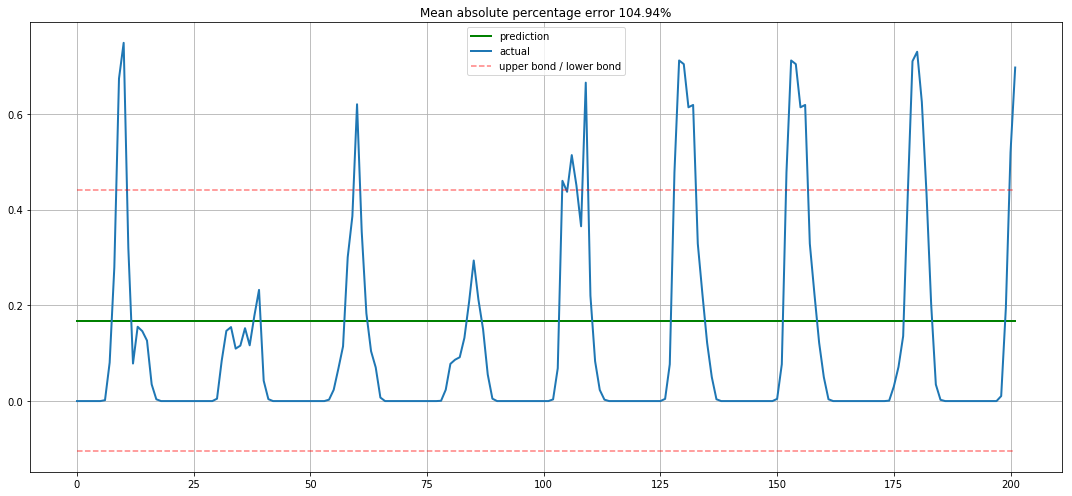

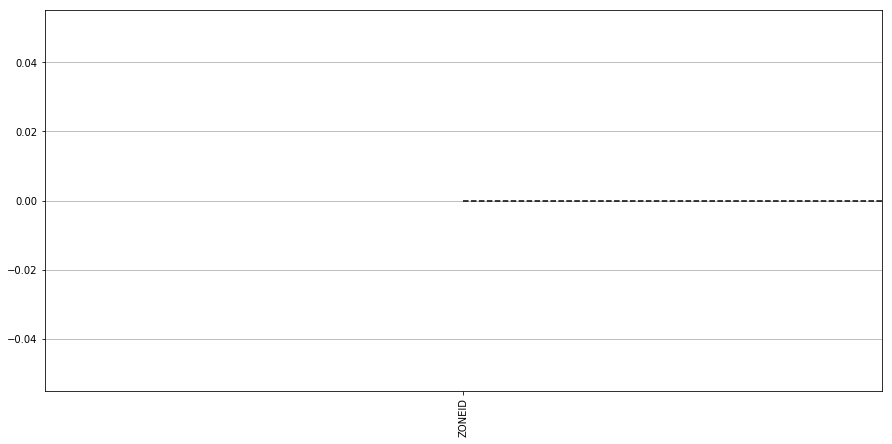

In [45]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

In [88]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing,ExponentialSmoothing

In [95]:
#create class
data = df.drop('ZONEID',axis=1)
model = ExponentialSmoothing(data)

NotImplementedError: Can only dampen the trend component

In [77]:
data

,POWER
TIMESTAMP,
2012-04-01 01:00:00,0.754103
2012-04-01 02:00:00,0.555000
2012-04-01 03:00:00,0.438397
2012-04-01 04:00:00,0.145449
2012-04-01 05:00:00,0.111987
2012-04-01 06:00:00,0.057244
2012-04-01 07:00:00,0.088718
2012-04-01 08:00:00,0.030064
2012-04-01 09:00:00,0.000128


In [90]:
# fit model
model_fit = model.fit()

In [93]:
# make prediction
yhat = model_fit.predict(end='2018-08-31')

In [94]:
yhat

2014-06-01 01:00:00    0.087949
2014-06-01 02:00:00    0.087949
2014-06-01 03:00:00    0.087949
2014-06-01 04:00:00    0.087949
2014-06-01 05:00:00    0.087949
2014-06-01 06:00:00    0.087949
2014-06-01 07:00:00    0.087949
2014-06-01 08:00:00    0.087949
2014-06-01 09:00:00    0.087949
2014-06-01 10:00:00    0.087949
2014-06-01 11:00:00    0.087949
2014-06-01 12:00:00    0.087949
2014-06-01 13:00:00    0.087949
2014-06-01 14:00:00    0.087949
2014-06-01 15:00:00    0.087949
2014-06-01 16:00:00    0.087949
2014-06-01 17:00:00    0.087949
2014-06-01 18:00:00    0.087949
2014-06-01 19:00:00    0.087949
2014-06-01 20:00:00    0.087949
2014-06-01 21:00:00    0.087949
2014-06-01 22:00:00    0.087949
2014-06-01 23:00:00    0.087949
2014-06-02 00:00:00    0.087949
2014-06-02 01:00:00    0.087949
2014-06-02 02:00:00    0.087949
2014-06-02 03:00:00    0.087949
2014-06-02 04:00:00    0.087949
2014-06-02 05:00:00    0.087949
2014-06-02 06:00:00    0.087949
                         ...   
2018-08-